In [1]:
import os
import cv2
import json
import time
import joblib
import pandas as pd
import numpy as np

import imageio
import tensorflow as tf
import librosa
import librosa.display
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal.windows import hamming

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle, class_weight
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score, accuracy_score

import keras
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, LeakyReLU, Conv2DTranspose
from keras.optimizers import Adam
from keras.models import load_model
from keras.applications.mobilenet_v3 import MobileNetV3Large, preprocess_input

2024-03-14 20:07:25.170834: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-14 20:07:25.682867: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-14 20:07:27.494982: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/bmarghescu/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2024-03-14 20:07:27.494982: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugi

In [2]:
DATASET_DIR = "Datasets/Converted Datasets/EMO-IIT"
SPECTROGRAM_DIR = "Spectrograms/EMO-IIT/Converted_Log"
TF_RECORDS_DIR = "TFRecords/EMO-IIT_AutoEncoder"
TF_RECORDS_NAME = "EMO-IIT_converted_log_AutoEncoder.tfrecords"
MODEL_DIR = "Models"
MODEL_NAME = "EMO-IIT_converted_log_MobileNetV3Large.h5"
MODEL_NAME_AE = "EMO-IIT_converted_log_AutoEncoder.h5"
THRESHOLD_AE = 0.25
NUM_CLASSES_POSITIVE = 5
NUM_CLASSES_NEGATIVE = 3
NUM_CLASSES = NUM_CLASSES_POSITIVE + NUM_CLASSES_NEGATIVE
SAMPLE_RATE = 8000
BATCH_SIZE = 32
EPOCHS = 100
RANDOM_SEED = 42

In [3]:
def create_dataframe_emodb():
    EMOTION_DICT_EMODB = {'W': 'anger', 'L': 'boredom', 'E': 'disgust', 'A': 'fear', 'F': 'happiness', 'T': 'sadness', 'N': 'neutral'}
    if DATASET_DIR != "Datasets/EmoDB" and DATASET_DIR != "Datasets/Converted Datasets/EmoDB":
        raise Exception("DATASET_DIR must be set to 'Datasets/EmoDB' or 'Datasets/Converted Datasets/EmoDB' for EmoDB dataset")
    file_person, file_gender, file_emotion, file_path = [], [], [], []
    file_list = os.listdir(DATASET_DIR)
    for file in file_list:
        person = int(file[0:2])
        gender = 'male' if person in [3, 10, 11, 12, 15] else 'female'
        emotion = EMOTION_DICT_EMODB[file[5]]
        file_person.append(person)
        file_gender.append(gender)
        file_emotion.append(emotion)
        file_path.append(os.path.join(DATASET_DIR, file))
    file_dict = {'person': file_person, 'gender': file_gender, 'emotion': file_emotion, 'path': file_path}
    emodb_df = pd.DataFrame(file_dict)
    return emodb_df

In [4]:
def create_dataframe_emoiit():
    if DATASET_DIR != "Datasets/EMO-IIT" and DATASET_DIR != "Datasets/Converted Datasets/EMO-IIT":
        raise Exception("DATASET_DIR must be set to 'Datasets/EMO-IIT' or 'Datasets/Converted Datasets/EMO-IIT' for EMO-IIT dataset")
    file_emotion, file_path = [], []
    emotion_dir_list = os.listdir(DATASET_DIR)
    for emotion_dir in emotion_dir_list:
        file_list = os.listdir(os.path.join(DATASET_DIR, emotion_dir))
        for file in file_list:
            if file.endswith('.wav'):
                file_emotion.append(emotion_dir)
                file_path.append(os.path.join(DATASET_DIR, emotion_dir, file))
    file_dict = {'emotion': file_emotion, 'path': file_path}
    emoiit_df = pd.DataFrame(file_dict)
    emoiit_df = pd.DataFrame(shuffle(emoiit_df, random_state=RANDOM_SEED), columns=emoiit_df.columns).reset_index(drop=True, inplace=False)
    return emoiit_df

In [5]:
def create_dataframe_emoiit_autoencoder():
    if DATASET_DIR != "Datasets/EMO-IIT" and DATASET_DIR != "Datasets/Converted Datasets/EMO-IIT":
        raise Exception("DATASET_DIR must be set to 'Datasets/EMO-IIT' or 'Datasets/Converted Datasets/EMO-IIT' for EMO-IIT dataset")
    file_emotion_positive, file_emotion_negative, file_path_positive, file_path_negative = [], [], [], []
    emotion_dir_list = os.listdir(DATASET_DIR)
    for emotion_dir in emotion_dir_list:
        file_list = os.listdir(os.path.join(DATASET_DIR, emotion_dir))
        for file in file_list:
            if file.endswith('.wav'):
                if emotion_dir in ['anger', 'irritation', 'fear']:
                    file_emotion_negative.append(emotion_dir)
                    file_path_negative.append(os.path.join(DATASET_DIR, emotion_dir, file))
                else:
                    file_emotion_positive.append(emotion_dir)
                    file_path_positive.append(os.path.join(DATASET_DIR, emotion_dir, file))
    file_dict_positive = {'emotion': file_emotion_positive, 'path': file_path_positive}
    file_dict_negative = {'emotion': file_emotion_negative, 'path': file_path_negative}
    emoiit_positive_df = pd.DataFrame(file_dict_positive)
    emoiit_positive_df = pd.DataFrame(shuffle(emoiit_positive_df, random_state=RANDOM_SEED), columns=emoiit_positive_df.columns).reset_index(drop=True, inplace=False)
    emoiit_negative_df = pd.DataFrame(file_dict_negative)
    emoiit_negative_df = pd.DataFrame(shuffle(emoiit_negative_df, random_state=RANDOM_SEED), columns=emoiit_negative_df.columns).reset_index(drop=True, inplace=False)
    return emoiit_positive_df, emoiit_negative_df

In [6]:
def create_dataframe_emoiit_separate_speakers():
    assert (DATASET_DIR == "Datasets/EMO-IIT_Separate_Speakers" or DATASET_DIR == "Datasets/Converted Datasets/EMO-IIT_Separate_Speakers"), "DATASET_DIR must be set to 'Datasets/EMO-IIT_Separate_Speakers' or 'Datasets/Converted Datasets/EMO-IIT_Separate_Speakers'"
    file_emotion_train, file_emotion_test, file_path_train, file_path_test = [], [], [], []
    dataset_type = os.listdir(DATASET_DIR)
    for type in dataset_type:
        emotion_dir_list = os.listdir(os.path.join(DATASET_DIR, type))
        for emotion_dir in emotion_dir_list:
            emotion_dir_path = os.path.join(DATASET_DIR, type, emotion_dir)
            emotion_dir_files = os.listdir(emotion_dir_path)
            for file in emotion_dir_files:
                if file.endswith(".wav"):
                    if type == "train":
                        file_emotion_train.append(emotion_dir)
                        file_path_train.append(os.path.join(emotion_dir_path, file))
                    elif type == "test":
                        file_emotion_test.append(emotion_dir)
                        file_path_test.append(os.path.join(emotion_dir_path, file))
    df_train = pd.DataFrame({"emotion": file_emotion_train, "path": file_path_train})
    df_train = pd.DataFrame(shuffle(df_train, random_state=RANDOM_SEED), columns=df_train.columns).reset_index(drop=True, inplace=False)
    df_test = pd.DataFrame({"emotion": file_emotion_test, "path": file_path_test})
    df_test = pd.DataFrame(shuffle(df_test, random_state=RANDOM_SEED), columns=df_test.columns).reset_index(drop=True, inplace=False)
    return df_train, df_test

In [7]:
def create_dataframe_ravdess():
    emotion_list = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
    if DATASET_DIR != "Datasets/RAVDESS/audio_speech_actors_01-24" and DATASET_DIR != "Datasets/Converted Datasets/RAVDESS":
        raise Exception("DATASET_DIR must be set to 'Datasets/RAVDESS/audio_speech_actors_01-24' or 'Datasets/Converted Datasets/RAVDESS' for RAVDESS dataset")
    file_person, file_gender, file_emotion, file_intensity, file_path = [], [], [], [], []
    person_dir_list = os.listdir(DATASET_DIR)
    for person_dir in person_dir_list:
        if person_dir.startswith("Actor_"):
            person = int(person_dir.split("_")[1])
            file_list_person = os.listdir(os.path.join(DATASET_DIR, person_dir))
            for file in file_list_person:
                if file.endswith(".wav"):
                    file_person.append(person)
                    file_path.append(os.path.join(DATASET_DIR, person_dir, file))
                    file_gender.append("male" if person % 2 == 1 else "female")
                    file_emotion.append(emotion_list[int(file.split("-")[2]) - 1])
                    file_intensity.append(int(file.split("-")[3].split(".")[0]))
    file_dict = {'person': file_person, 'gender': file_gender, 'emotion': file_emotion, 'intensity': file_intensity, 'path': file_path}
    ravdess_df = pd.DataFrame(file_dict)
    ravdess_df = pd.DataFrame(shuffle(ravdess_df, random_state=RANDOM_SEED), columns=ravdess_df.columns).reset_index(drop=True, inplace=False)
    return ravdess_df

In [8]:
def preprocess_dataset(ser_df, dataset_type, ohe=None, fold=None):
    audio_block_list = []
    emotion_list = []
    for row in tqdm(ser_df.itertuples(), desc=f"Preprocessing audio files dataset - {dataset_type}", total=len(ser_df)):
        data, _ = librosa.load(row.path, sr=SAMPLE_RATE)
        if data.shape[0] < SAMPLE_RATE:
            data = np.pad(data, (0, SAMPLE_RATE - data.shape[0]), 'constant')
        frames = librosa.util.frame(data, frame_length=SAMPLE_RATE, hop_length=int(SAMPLE_RATE/100)).T
        for frame in frames:
            audio_block_list.append(frame)
            emotion_list.append(row.emotion)
    audio_block_list = np.array(audio_block_list)
    emotion_list = np.array(emotion_list)
    if ohe is None:
        ohe = OneHotEncoder(categories='auto', sparse=False)
        emotion_list = ohe.fit_transform(emotion_list[:, np.newaxis])
        ohe_path = os.path.join(MODEL_DIR, MODEL_NAME.replace(".h5", f"_fold_{fold + 1}_ohe.pkl")) if fold is not None else os.path.join(MODEL_DIR, MODEL_NAME.replace(".h5", "_ohe.pkl"))
        joblib.dump(ohe, ohe_path)
    else:
        emotion_list = ohe.transform(emotion_list[:, np.newaxis])
    return audio_block_list, emotion_list

In [9]:
def preprocess_dataset_autoencoder(ser_df, dataset_type, ohe=None, fold=None):
    audio_block_list = []
    emotion_list = []
    for row in tqdm(ser_df.itertuples(), desc=f"Preprocessing audio files dataset - {dataset_type}", total=len(ser_df)):
        data, _ = librosa.load(row.path, sr=SAMPLE_RATE)
        if data.shape[0] < SAMPLE_RATE:
            data = np.pad(data, (0, SAMPLE_RATE - data.shape[0]), 'constant')
        frames = librosa.util.frame(data, frame_length=SAMPLE_RATE, hop_length=int(SAMPLE_RATE/100)).T
        for frame in frames:
            audio_block_list.append(frame)
            emotion_list.append(row.emotion)
    audio_block_list = np.array(audio_block_list)
    emotion_list = np.array(emotion_list)
    if ohe is None:
        ohe = OneHotEncoder(categories='auto', sparse=False)
        emotion_list = ohe.fit_transform(emotion_list[:, np.newaxis])
        ohe_path = os.path.join(MODEL_DIR, MODEL_NAME.replace(".h5", f"_fold_{fold + 1}_{dataset_type}_ohe.pkl")) if fold is not None else os.path.join(MODEL_DIR, MODEL_NAME.replace(".h5", f"_{dataset_type}_ohe.pkl"))
        joblib.dump(ohe, ohe_path)
    else:
        emotion_list = ohe.transform(emotion_list[:, np.newaxis])
    return audio_block_list, emotion_list

In [10]:
def create_spectrogram_log(data, sr):
    X = np.abs(librosa.stft(data, window=hamming(int(np.round(sr / 1000) * 32)), n_fft=int(np.round(sr / 1000) * 32), hop_length=int(np.round(sr / 1000) * 4)))
    Xdb = librosa.amplitude_to_db(np.abs(X), ref=np.max)
    cmap = plt.cm.jet
    norm = plt.Normalize(vmin=-90, vmax=-7)
    image = cmap(norm(Xdb))
    image = image[:, :, :3]
    image = cv2.normalize(src=np.flip(image, axis=0), dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_LINEAR)
    return image

In [11]:
def create_spectrogram_linear(data, sr):
    X = np.abs(librosa.stft(data, window=hamming(int(np.round(sr / 1000) * 32)), n_fft=int(np.round(sr / 1000) * 32), hop_length=int(np.round(sr / 1000) * 4)))
    cmap = plt.cm.jet
    norm = plt.Normalize(vmin=np.amin(X), vmax=np.amax(X))
    image = cmap(norm(X))
    image = image[:, :, :3]
    image = cv2.normalize(src=np.flip(image, axis=0), dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_LINEAR)
    return image

In [12]:
def create_spectrogram_mel(data, sr):
    Xmel = np.abs(librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128, window=hamming(int(np.round(sr / 1000) * 32)), n_fft=int(np.round(sr / 1000) * 32), hop_length=int(np.round(sr / 1000) * 4)))
    X_mel_db = librosa.amplitude_to_db(Xmel, ref=np.max)
    cmap = plt.cm.jet
    norm = plt.Normalize(vmin=-90, vmax=-7)
    image = cmap(norm(X_mel_db))
    image = image[:, :, :3]
    image = cv2.normalize(src=np.flip(image, axis=0), dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_LINEAR)
    return image

In [13]:
def create_spectrogram_hpss(data, sr):
    X = librosa.stft(data, window=hamming(int(np.round(sr / 1000) * 32)), n_fft=int(np.round(sr / 1000) * 32), hop_length=int(np.round(sr / 1000) * 4))
    X_harmonic, X_percussive = librosa.decompose.hpss(X)
    X_db = librosa.amplitude_to_db(np.abs(X), ref=np.max)
    X_harmonic_db = librosa.amplitude_to_db(np.abs(X_harmonic), ref=np.max)
    X_percussive_db = librosa.amplitude_to_db(np.abs(X_percussive), ref=np.max)
    image = np.hstack((X_db, X_harmonic_db, X_percussive_db))
    cmap = plt.cm.jet
    norm = plt.Normalize(vmin=-90, vmax=-7)
    image = cmap(norm(image))
    image = image[:, :, :3]
    image = cv2.normalize(src=np.flip(image, axis=0), dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_LINEAR)
    return image

In [14]:
def image_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(
        bytes_list=tf.train.BytesList(value=[tf.io.encode_png(value).numpy()])
    )


def bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value.encode()]))


def float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

In [15]:
def create_example(image, path, emotion_id):
    feature = {
        "image": image_feature(image),
        "path": bytes_feature(path),
        "emotion_id": float_feature(emotion_id),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

In [16]:
def parse_tfrecord_train_autoencoder(example):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "path": tf.io.FixedLenFeature([], tf.string),
        "emotion_id": tf.io.FixedLenFeature([NUM_CLASSES_POSITIVE], tf.float32),
    }
    example = tf.io.parse_single_example(example, feature_description)
    example["image"] = tf.io.decode_png(example["image"], channels=3)
    return example

In [17]:
def parse_tfrecord_test_autoencoder(example):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "path": tf.io.FixedLenFeature([], tf.string),
        "emotion_id": tf.io.FixedLenFeature([NUM_CLASSES_NEGATIVE], tf.float32),
    }
    example = tf.io.parse_single_example(example, feature_description)
    example["image"] = tf.io.decode_png(example["image"], channels=3)
    return example

In [18]:
def create_example_test(image, path, emotion_id, sample_weight):
    feature = {
        "image": image_feature(image),
        "path": bytes_feature(path),
        "emotion_id": float_feature(emotion_id),
        "sample_weight": float_feature(sample_weight),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

In [19]:
def parse_tfrecord(example):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "path": tf.io.FixedLenFeature([], tf.string),
        "emotion_id": tf.io.FixedLenFeature([NUM_CLASSES], tf.float32),
    }
    example = tf.io.parse_single_example(example, feature_description)
    example["image"] = tf.io.decode_png(example["image"], channels=3)
    return example

In [20]:
def parse_tfrecord_train(example):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "path": tf.io.FixedLenFeature([], tf.string),
        "emotion_id": tf.io.FixedLenFeature([NUM_CLASSES], tf.float32),
    }
    example = tf.io.parse_single_example(example, feature_description)
    example["image"] = tf.io.decode_png(example["image"], channels=3)
    return example


def parse_tfrecord_test(example):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "path": tf.io.FixedLenFeature([], tf.string),
        "emotion_id": tf.io.FixedLenFeature([NUM_CLASSES], tf.float32),
        "sample_weight": tf.io.FixedLenFeature([1], tf.float32),
    }
    example = tf.io.parse_single_example(example, feature_description)
    example["image"] = tf.io.decode_png(example["image"], channels=3)
    return example

In [21]:
def create_spectrogram_dataset(audio_block_list, emotion_list, sr, create_spectrogram, dataset_type="train"):
    if dataset_type not in ["train", "dev", "test"]:
        raise ValueError("dataset_type must be 'train', 'dev' or 'test'")
    if not os.path.exists(os.path.join(TF_RECORDS_DIR, dataset_type)):
        os.makedirs(os.path.join(TF_RECORDS_DIR, dataset_type))
    with tf.io.TFRecordWriter(os.path.join(TF_RECORDS_DIR, dataset_type, TF_RECORDS_NAME)) as writer:
        for index, block in enumerate(tqdm(audio_block_list, desc=f"Creating Spectrogram Dataset - {dataset_type}", total=audio_block_list.shape[0])):
            image = create_spectrogram(block, sr)
            if not os.path.exists(os.path.join(SPECTROGRAM_DIR, dataset_type)):
                os.makedirs(os.path.join(SPECTROGRAM_DIR, dataset_type))
            image_path = os.path.join(SPECTROGRAM_DIR, dataset_type, f"{index:05d}.png")
            imageio.imsave(image_path, image)
            image = tf.io.decode_png(tf.io.read_file(image_path))
            example = create_example(image, image_path, emotion_list[index])
            writer.write(example.SerializeToString())

In [22]:
def preprocess_input_autoencoder(img):
    img = img / 255.0
    return img

In [23]:
def prepare_sample(features):
    image = preprocess_input(tf.cast(features["image"], tf.float32))
    return image, features["emotion_id"]

In [24]:
def prepare_sample_autoencoder(features):
    image = preprocess_input_autoencoder(tf.cast(features["image"], tf.float32))
    return image, image

In [25]:
def prepare_sample_train(features):
    image = preprocess_input(tf.cast(features["image"], tf.float32))
    # image = preprocess_input_alexnet(tf.cast(features["image"], tf.float32))
    return image, features["emotion_id"]


def prepare_sample_test(features):
    image = preprocess_input(tf.cast(features["image"], tf.float32))
    # image = preprocess_input_alexnet(tf.cast(features["image"], tf.float32))
    sample_weight = tf.squeeze(features["sample_weight"])
    return image, features["emotion_id"], sample_weight

In [26]:
def get_dataset(batch_size, dataset_type="train"):
    if dataset_type not in ["train", "dev", "test"]:
        raise ValueError("dataset_type must be 'train', 'dev' or 'test'")
    AUTOTUNE = tf.data.AUTOTUNE
    dataset = (
        tf.data.TFRecordDataset(os.path.join(TF_RECORDS_DIR, dataset_type, TF_RECORDS_NAME), num_parallel_reads=AUTOTUNE)
        .map(parse_tfrecord, num_parallel_calls=AUTOTUNE)
        .map(prepare_sample, num_parallel_calls=AUTOTUNE)
        .shuffle(batch_size * 10, seed=RANDOM_SEED)
        .batch(batch_size)
        .prefetch(AUTOTUNE)
    )
    return dataset

In [27]:
def get_dataset_autoencoder(batch_size, dataset_type="train"):
    if dataset_type not in ["train", "dev", "test"]:
        raise ValueError("dataset_type must be 'train', 'dev' or 'test'")
    AUTOTUNE = tf.data.AUTOTUNE
    if dataset_type == "train" or dataset_type == "dev":
        dataset = (
            tf.data.TFRecordDataset(os.path.join(TF_RECORDS_DIR, dataset_type, TF_RECORDS_NAME), num_parallel_reads=AUTOTUNE)
            .map(parse_tfrecord_train_autoencoder, num_parallel_calls=AUTOTUNE)
            .map(prepare_sample_autoencoder, num_parallel_calls=AUTOTUNE)
            .shuffle(batch_size * 10, seed=RANDOM_SEED)
            .batch(batch_size)
            .prefetch(AUTOTUNE)
        )
    else:
        dataset = (
            tf.data.TFRecordDataset(os.path.join(TF_RECORDS_DIR, dataset_type, TF_RECORDS_NAME), num_parallel_reads=AUTOTUNE)
            .map(parse_tfrecord_test_autoencoder, num_parallel_calls=AUTOTUNE)
            .map(prepare_sample_autoencoder, num_parallel_calls=AUTOTUNE)
            .shuffle(batch_size * 10, seed=RANDOM_SEED)
            .batch(batch_size)
            .prefetch(AUTOTUNE)
        )
    return dataset

In [28]:
def SSIMLoss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

In [29]:
def SSIMLoss_batch(y_true, y_pred):
    return 1 - tf.image.ssim(y_true, y_pred, 1.0)

In [30]:
def create_ser_model():
    # Encoder
    encoder = Sequential([
        Conv2D(32, kernel_size=3, strides=1, padding='same', input_shape=(224, 224, 3)),
        BatchNormalization(),
        LeakyReLU(),
        Conv2D(64, kernel_size=3, strides=2, padding='same'),
        BatchNormalization(),
        LeakyReLU(),
        Conv2D(64, kernel_size=3, strides=2, padding='same'),
        BatchNormalization(),
        LeakyReLU(),
        Conv2D(64, kernel_size=3, strides=2, padding='same'),
        BatchNormalization(),
        LeakyReLU(),
        Conv2D(64, kernel_size=3, strides=2, padding='same'),
        BatchNormalization(),
        LeakyReLU(),
        Conv2D(64, kernel_size=3, strides=2, padding='same'),
        BatchNormalization(),
        LeakyReLU(),
    ], name='encoder')

    # Decoder
    decoder = Sequential([
        Conv2DTranspose(64, 3, strides=1, padding='same'),
        BatchNormalization(),
        LeakyReLU(),
        Conv2DTranspose(64, 3, strides=2, padding='same'),
        BatchNormalization(),
        LeakyReLU(),
        Conv2DTranspose(64, 3, strides=2, padding='same'),
        BatchNormalization(),
        LeakyReLU(),
        Conv2DTranspose(64, 3, strides=2, padding='same'),
        BatchNormalization(),
        LeakyReLU(),
        Conv2DTranspose(64, 3, strides=2, padding='same'),
        BatchNormalization(),
        LeakyReLU(),
        Conv2DTranspose(32, 3, strides=2, padding='same'),
        BatchNormalization(),
        LeakyReLU(),
        Conv2DTranspose(3, 3, strides=1, padding='same', activation='sigmoid'),
    ], name='decoder')

    # Autoencoder
    autoencoder = Sequential([
        encoder,
        decoder
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    autoencoder.compile(optimizer=optimizer, loss=tf.keras.losses.Huber(), metrics=['accuracy'])
    return autoencoder

In [31]:
def predict_emotion(image_true, model_ser, model_ae):
    image_true_ae = preprocess_input_autoencoder(image_true)
    reconstructed_pred = model_ae.predict(image_true_ae, verbose=0)
    anomaly_score = SSIMLoss_batch(image_true_ae, reconstructed_pred).numpy()
    emotion_pred = model_ser.predict(image_true, verbose=0)
    emotion_pred = np.argmax(emotion_pred, axis=1)
    anomaly_idx = np.where(anomaly_score < THRESHOLD_AE)[0]
    emotion_pred[anomaly_idx] = 6  # neutral index in ohe vector
    # if anomaly_score < THRESHOLD_AE:
    #     emotion_pred = np.array([0., 0., 0., 0., 0., 0., 1., 0.])  # neutral ohe vector
    return emotion_pred

In [32]:
def plot_history(history, model_name):
    fig, axs = plt.subplots(2, 1, figsize=(15, 15))
    fig.suptitle(model_name, size=20)
    axs[0].plot(history.history['loss'])
    axs[0].title.set_text('Training Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[1].plot(history.history['accuracy'])
    axs[1].title.set_text('Training Accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    plt.show()

In [33]:
def plot_training_curve(model_name):
    history_json = json.load(open(os.path.join(MODEL_DIR, model_name.replace(".h5", ".json")), "r"))
    plt.figure(figsize=(9, 6))
    plt.plot(history_json['accuracy'])
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.show()
    plt.figure(figsize=(9, 6))
    plt.plot(history_json['weighted_accuracy'])
    plt.xlabel("Epochs")
    plt.ylabel("Weighted Accuracy")
    plt.show()
    plt.figure(figsize=(9, 6))
    plt.plot(history_json['loss'])
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

In [34]:
def get_run_logdir(root_logdir):
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

In [35]:
ser_positive_df, _ = create_dataframe_emoiit_autoencoder()
ser_train_df, ser_dev_df = train_test_split(ser_positive_df, test_size=0.1, random_state=RANDOM_SEED, stratify=ser_positive_df.emotion)
audio_block_list_train, emotion_list_train = preprocess_dataset_autoencoder(ser_positive_df, "train")
ohe_train = joblib.load(os.path.join(MODEL_DIR, MODEL_NAME.replace(".h5", "_train_ohe.pkl")))
audio_block_list_dev, emotion_list_dev = preprocess_dataset_autoencoder(ser_dev_df, "dev", ohe=ohe_train)

Preprocessing audio files dataset - dev: 100%|██████████| 37/37 [00:01<00:00, 35.17it/s]


In [47]:
ser_real_df = create_dataframe_emoiit()
_, ser_test_df = train_test_split(ser_real_df, test_size=0.2, random_state=RANDOM_SEED, stratify=ser_real_df.emotion)
ohe_test = joblib.load(os.path.join(MODEL_DIR, "EMO-IIT_Separate_Speakers_log_VGG16_ohe.pkl"))
audio_block_list_test, emotion_list_test = preprocess_dataset(ser_test_df, "test", ohe=ohe_test)

Preprocessing audio files dataset - test:   0%|          | 0/113 [00:00<?, ?it/s]

Preprocessing audio files dataset - test: 100%|██████████| 113/113 [00:06<00:00, 17.90it/s]


In [48]:
# create_spectrogram_dataset(audio_block_list_train, emotion_list_train, sr=SAMPLE_RATE, create_spectrogram=create_spectrogram_log, dataset_type="train")
# create_spectrogram_dataset(audio_block_list_dev, emotion_list_dev, sr=SAMPLE_RATE, create_spectrogram=create_spectrogram_log, dataset_type="dev")
create_spectrogram_dataset(audio_block_list_test, emotion_list_test, sr=SAMPLE_RATE, create_spectrogram=create_spectrogram_log, dataset_type="test")

Creating Spectrogram Dataset - test:   0%|          | 0/8279 [00:00<?, ?it/s]2024-03-14 22:17:38.358859: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-14 22:17:38.362859: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-14 22:17:38.362859: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-14 22:17:38.362859: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-14 22:17:38.378860: I tensorflow/st

In [49]:
strategy = tf.distribute.MirroredStrategy()
num_gpus = strategy.num_replicas_in_sync
# num_gpus = 1
# train_dataset = get_dataset_autoencoder(batch_size=BATCH_SIZE * num_gpus, dataset_type="train")
# dev_dataset = get_dataset_autoencoder(batch_size=BATCH_SIZE * num_gpus, dataset_type="dev")
test_dataset = get_dataset(batch_size=BATCH_SIZE * num_gpus, dataset_type="test")

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


In [50]:
# if not os.path.exists(MODEL_DIR):
#     os.makedirs(MODEL_DIR)
# model = create_ser_model()
# model.summary()

In [51]:
# run_logdir = get_run_logdir(root_logdir=os.path.join(os.curdir, "logs\\fit\\"))
# tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
# checkpoint = ModelCheckpoint(os.path.join(MODEL_DIR, MODEL_NAME), verbose=1, monitor='accuracy', save_best_only=True, mode='auto')
# history = model.fit(x=train_dataset, class_weight=dict(enumerate(cls_weight)), epochs=EPOCHS, verbose=1, callbacks=[tensorboard_cb, checkpoint], validation_data=dev_dataset, shuffle=False, workers=8, use_multiprocessing=True)

In [52]:
# plot_history(history, model_name="Model EmoDB: Log Spectrogram")

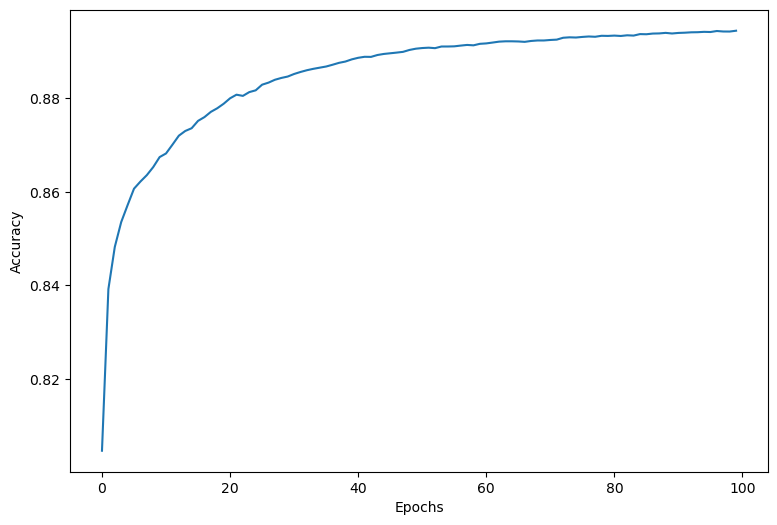

In [53]:
history_json = json.load(open(os.path.join(MODEL_DIR, MODEL_NAME_AE.replace(".h5", ".json")), "r"))
plt.figure(figsize=(9, 6))
plt.plot(history_json['accuracy'])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

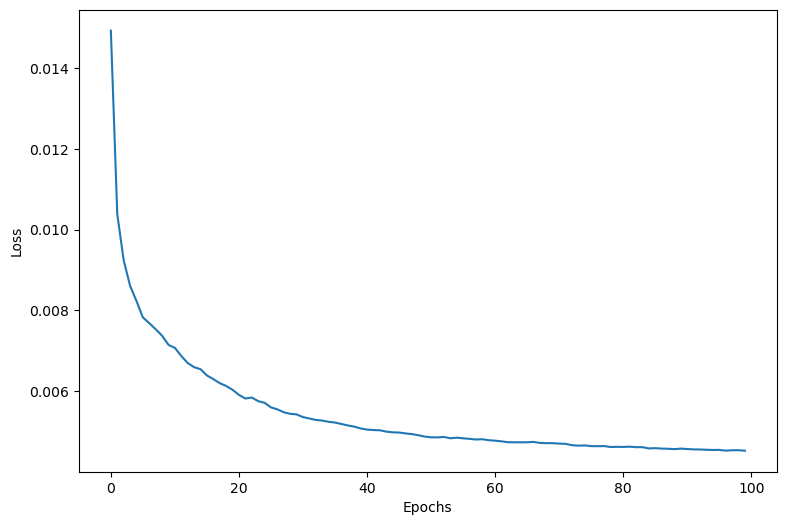

In [54]:
history_json = json.load(open(os.path.join(MODEL_DIR, MODEL_NAME_AE.replace(".h5", ".json")), "r"))
plt.figure(figsize=(9, 6))
plt.plot(history_json['loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [55]:
ohe_test.categories_

[array(['anger', 'boredom', 'disgust', 'fear', 'hapiness', 'irritation',
        'neutral', 'sadness'], dtype='<U10')]

In [56]:
test_dataset.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 8), dtype=tf.float32, name=None))>

In [57]:
test_dataset_slices = list(test_dataset.as_numpy_iterator())
x_true = np.concatenate([batch[0] for batch in test_dataset_slices], axis=0)
y_true = np.concatenate([batch[1] for batch in test_dataset_slices], axis=0)
y_true = ohe_test.inverse_transform(y_true)
y_true = np.where(np.isin(y_true, ['anger', 'irritation', 'fear']), y_true, 'neutral')
y_true = ohe_test.transform(y_true)
y_true = np.argmax(y_true, axis=1)

In [58]:
model_ser = load_model(os.path.join(MODEL_DIR, MODEL_NAME))
model_ae = load_model(os.path.join(MODEL_DIR, MODEL_NAME_AE))
for i in tqdm(range(0, x_true.shape[0], BATCH_SIZE), desc="Getting predictions for test set"):
    if i == 0:
        y_pred = predict_emotion(x_true[i:i+BATCH_SIZE], model_ser, model_ae)
    else:
        y_pred = np.concatenate((y_pred, predict_emotion(x_true[i:i+BATCH_SIZE], model_ser, model_ae)), axis=0)

Getting predictions for test set:   0%|          | 0/259 [00:00<?, ?it/s]2024-03-14 22:26:58.457173: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8301
2024-03-14 22:27:00.013272: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: couldn't get temp CUBIN file name
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
Getting predictions for test set: 100%|██████████| 259/259 [02:23<00:00,  1.80it/s]


In [59]:
print(f"Accuracy: {accuracy_score(y_true, y_pred):.2%}")

Accuracy: 73.48%


In [60]:
print(classification_report(y_true, y_pred, target_names=ohe_test.categories_[0]))

              precision    recall  f1-score   support

       anger       0.90      0.90      0.90       503
     boredom       0.00      0.00      0.00         0
     disgust       0.00      0.00      0.00         0
        fear       0.78      0.91      0.84       366
    hapiness       0.00      0.00      0.00         0
  irritation       1.00      0.98      0.99      5006
     neutral       0.99      0.16      0.27      2404
     sadness       0.00      0.00      0.00         0

    accuracy                           0.73      8279
   macro avg       0.46      0.37      0.38      8279
weighted avg       0.98      0.73      0.77      8279



/home/bmarghescu/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bmarghescu/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bmarghescu/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


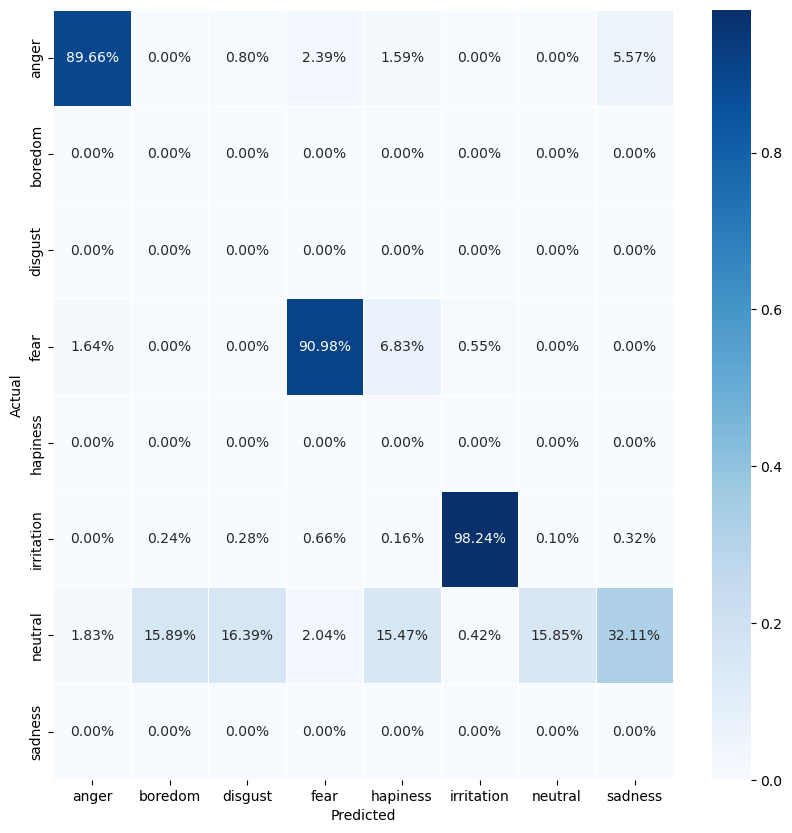

In [61]:
confusion_mat = confusion_matrix(y_true, y_pred, normalize="true")
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_mat, annot=True, fmt=".2%", xticklabels=ohe_test.categories_[0], yticklabels=ohe_test.categories_[0], cmap="Blues", linewidths=0.5)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()